In [1]:
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np

In [2]:
# Loading the cleaned dataset, in which within-mouse outliers have been removed and then the mean or median per mouse has been calculated
# Outlier biological replicates are still present.  Some mice are missing data for some proteins.
# (8/76 proteins are missing at least one data point.)
data_means   = pd.read_csv('Output/Data_Cortex_Nuclear_Means_Clean.csv')
data_medians = pd.read_csv('Output/Data_Cortex_Nuclear_Medians_Clean.csv')
# Clustermap doesn't work with null values, so remove proteins that have any missing values
data_meansnomissing   = data_means.loc[:,data_means.isnull().sum()==0]
data_mediansnomissing = data_medians.loc[:,data_medians.isnull().sum()==0]
# Then remove all non-protein variables, saving class for color-coding
groups = data_meansnomissing.pop('class')
data_meansnomissing   = data_meansnomissing.drop(['Genotype','Behavior','Treatment','Mouse'],axis=1)
data_mediansnomissing = data_mediansnomissing.drop(['class','Genotype','Behavior','Treatment','Mouse'],axis=1)
#Also edit data_means and data_medians so that Behavior variable values are better labeled
data_means.replace(to_replace='C/S', value='Learning', inplace=True)
data_means.replace(to_replace='S/C', value='NoLearning', inplace=True)
data_medians.replace(to_replace='C/S', value='Learning', inplace=True)
data_medians.replace(to_replace='S/C', value='NoLearning', inplace=True)

In [3]:
# Set up color code to use for all graphs
colors = [(0.3, 0.3,  1.0), (0.6, 0.6, 1.0), #Control genotype, Learning = dark blues; opaque = treated
          (0.3, 0.65, 1.0), (0.6, 0.8, 1.0), #Control genotype, No learning = light blues; opaque = treated
          (1.0, 0.3,  0.3), (1.0, 0.6, 0.6), #Down Syndrome, Learning = reds; opaque = treated
          (1.0, 0.65, 0.3), (1.0, 0.8, 0.6)] #Down Syndrome, No Learning = oranges; opaque = treated
# Create color code for row clustering
row_colors = groups.map(dict(zip(groups.unique(), colors)))
group_names = ['Control Learning Treated',
               'Control Learning Untreated',
               'Control NoLearning Treated',
               'Control NoLearning Untreated',
               'DownSyndrome Learning Treated',
               'DownSyndrome Learning Untreated',
               'DownSyndrome NoLearning Treated',
               'DownSyndrome NoLearning Untreated']

# Set small font for cluster maps
mpl.rcParams['font.size'] = 10

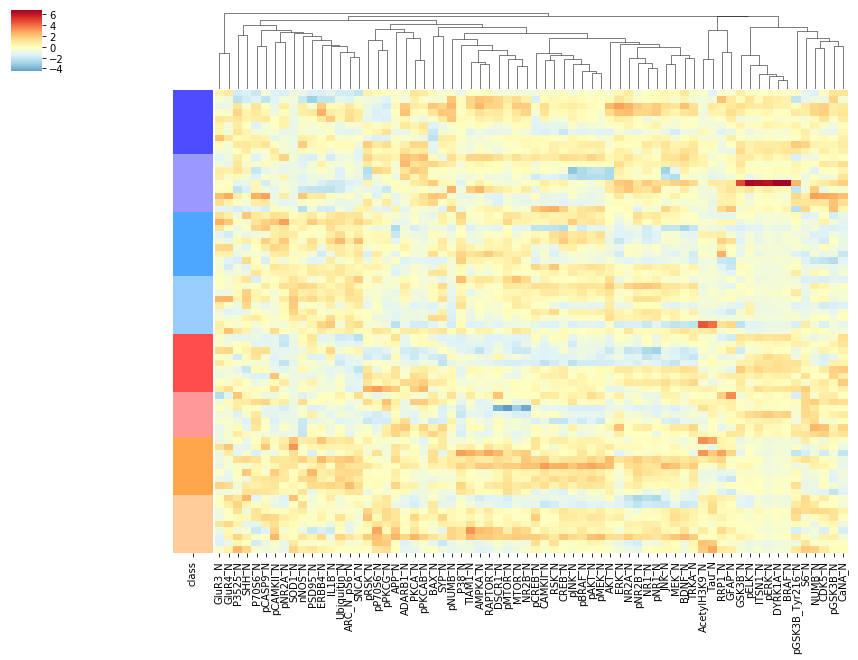

In [4]:
cluster_means=sns.clustermap(data_meansnomissing,center=0,cmap='RdYlBu_r',z_score=1,row_colors=row_colors,xticklabels=True,
                   yticklabels=False,figsize=(15,10),row_cluster=False)

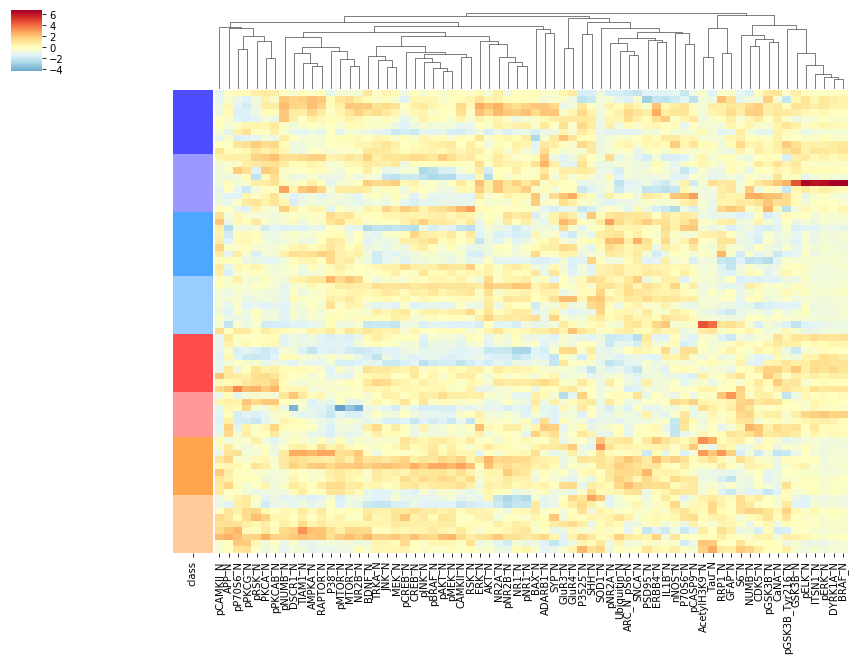

In [5]:
cluster_medians=sns.clustermap(data_mediansnomissing,center=0,cmap='RdYlBu_r',z_score=1,row_colors=row_colors,xticklabels=True,
                   yticklabels=False,figsize=(15,10),row_cluster=False)

In [6]:
# Font needed to be smaller for cluster graphs; now increase it for remaining plots
mpl.rcParams['font.size'] = 15

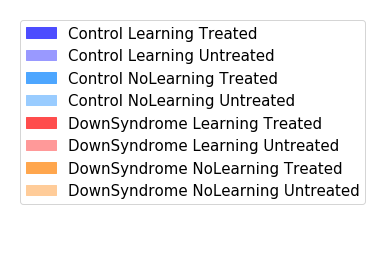

In [7]:
def make_legend(colors,labels,axes = None, **kwargs):
    # makes a simple legend with colored patches and labels.  colors needs to be at least as long as labels.
    if axes is None:
        axes = plt.axes(frameon=False)
        axes.set_axis_off()
    patches = [mpatches.Patch(color=colors[i], label=labels[i]) for i in range(len(labels))]
    leg = axes.legend(handles=patches, **kwargs)
    plt.show()
    return leg

_ = make_legend(colors,group_names)

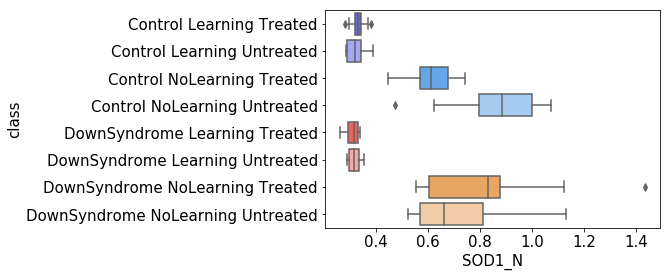

In [8]:
def box_plot_groups(protein):
    ax = sns.boxplot(y = groups, x = data_means[protein], palette = colors, notch = False)
    ax.set(yticklabels=group_names)

_ = box_plot_groups('SOD1_N')

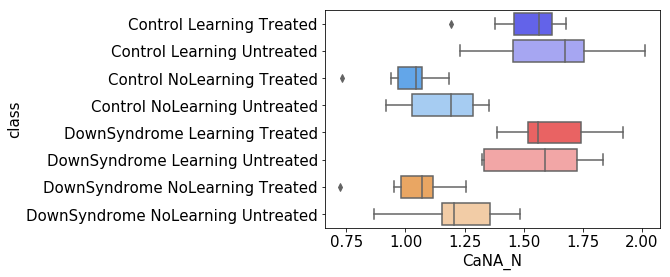

In [9]:
_ = box_plot_groups('CaNA_N')

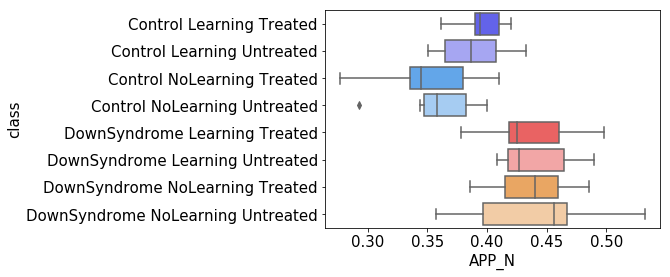

In [10]:
_ = box_plot_groups('APP_N')

In [11]:
GenoBehavProteins = ['pNUMB_N', 'RAPTOR_N', 'TIAM1_N', 
                     'NR2B_N',  'AMPKA_N',  'NR2A_N', 
                     'BDNF_N',  'MTOR_N',   'ERK_N', 
                     'PKCA_N',  'Bcatenin_N']

In [12]:
AOV_results = pd.read_excel('Output/AOV_Results.xls')
AOV_results.rename({'Unnamed: 0': 'Protein'}, inplace = True, axis = 1)
AOV_results = AOV_results.set_index('Protein')
AOV_results.sort_values('Geno_Behav', ascending = True).head()

,Genotype,Behavior,Treatment,Geno_Behav,Geno_Treat,Behav_Treat,Triple_Interact
Protein,,,,,,,
pNUMB_N,0.695546,0.000446,0.506109,0.000093,0.106602,0.296936,0.950578
RAPTOR_N,0.307076,0.010654,0.166440,0.000490,0.744319,0.455431,0.797829
TIAM1_N,0.134548,0.255398,0.908689,0.000654,0.820715,0.323144,0.749466
NR2B_N,0.028777,0.000295,0.082955,0.000812,0.181322,0.453416,0.186226
AMPKA_N,0.041018,0.475675,0.670274,0.001096,0.609798,0.589713,0.495915


In [13]:
AOV_results_log = -np.log10(AOV_results)

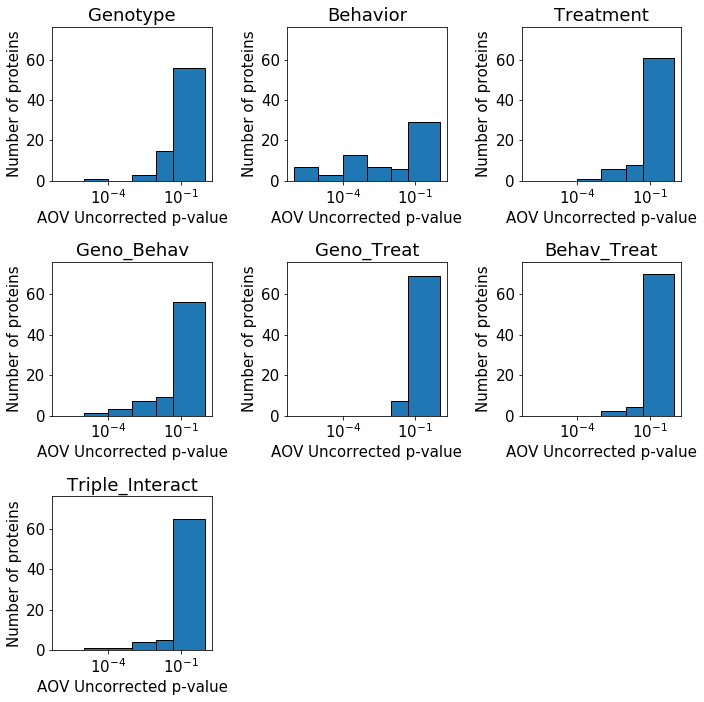

In [14]:
bins = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.05]
bins = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.05, 1]
fig = plt.figure(figsize = (10, 10))
for idx, comparison in enumerate(AOV_results.columns):
    ax = plt.subplot(3,3,idx+1)
    _ = AOV_results[comparison].plot(kind = 'hist', alpha = 1, bins = bins, stacked = False, ax = ax, edgecolor = 'k', logx = True)
    _ = plt.xlabel('AOV Uncorrected p-value')
    _ = plt.ylabel('Number of proteins')
    _ = plt.title(comparison)
    #_ = plt.ylim([0,15])
    _ = plt.ylim([0,76])
plt.tight_layout()

In [15]:
# Plot an interection plot for each protein to see effect of Genotype and Behavior,
# showing mean +/- SEM
def get_means_and_sems(df, variables):
    # variables is a list of column names.
    # groups data by variables and returns mean and S.E.M. dataframes
    means  = df.groupby(variables).mean()
    stds    = df.groupby(variables).std()
    counts = df.groupby(variables).count()
    sems   = stds / np.sqrt(counts)
    return means, sems

def interaction_plot(points, error_bars, protein, ind_order, axis):
    x_grouping    = points.index.names[ind_order[0]]
    line_grouping = points.index.names[ind_order[1]]
    point_vals = pd.pivot_table(data = points, 
                                values = protein, columns = x_grouping, index = line_grouping)
    error_vals = pd.pivot_table(data = error_bars, 
                                values = protein, columns = x_grouping, index = line_grouping)
    _ = point_vals.plot(yerr = error_vals, xlim = [-0.3,1.3], xticks = [0,1], ax = axis)
    _ = plt.title(protein)


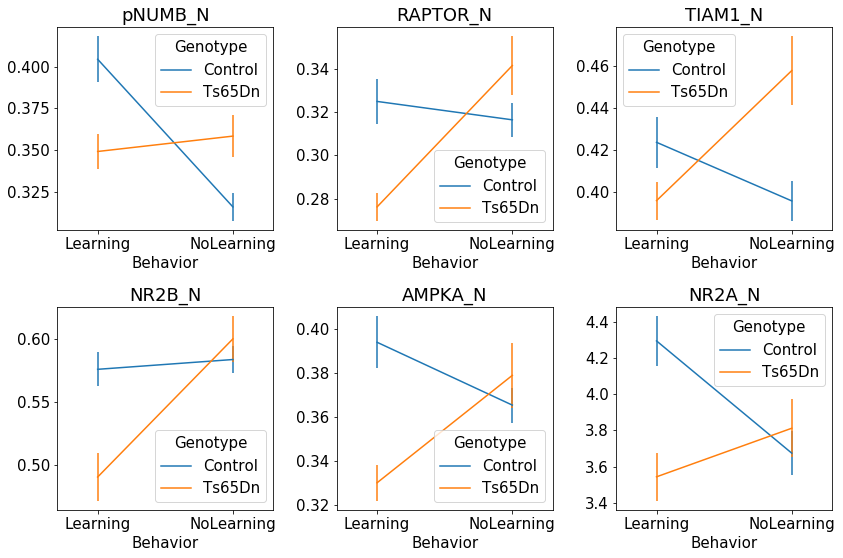

In [16]:
rows = 2
cols = 3
ngraphs = rows * cols
_ = plt.figure(figsize = [cols * 4, rows * 4])

means, sems = get_means_and_sems(data_means, ['Behavior','Genotype'])

for idx, protein in enumerate(GenoBehavProteins[0:ngraphs]):
    ax = plt.subplot(rows,cols,idx+1)
    _ = interaction_plot(means, sems, protein, [1,0], ax)
    
_ = plt.tight_layout()  

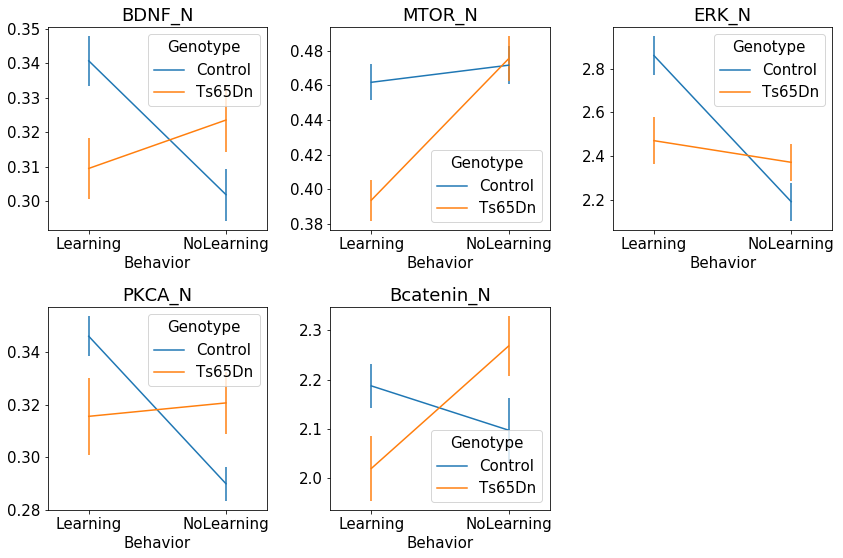

In [17]:
_ = plt.figure(figsize = [cols * 4, rows * 4])
for idx, protein in enumerate(GenoBehavProteins[ngraphs:]):
    ax = plt.subplot(rows,cols,idx+1)
    _ = interaction_plot(means, sems, protein, [1,0], ax)
    
_ = plt.tight_layout()  

In [18]:
accuracy_df = pd.read_csv('Output/ClassificationAccuracy_all.csv')
accuracy_df.rename({'Unnamed: 0': 'Classifier'}, axis = 1, inplace = True)
accuracy_df = accuracy_df.set_index('Classifier')
accuracy_df

,Genotype_Accuracy,Behavior_Accuracy,Treatment_Accuracy,Overall_Accuracy
Classifier,,,,
Nearest Neighbors,0.733333,0.866667,0.466667,0.266667
Random Forest,0.933333,1.000000,0.400000,0.400000
Gradient Boost,0.733333,1.000000,0.666667,0.466667
AdaBoost,0.533333,1.000000,0.533333,0.266667
Support Vector,0.733333,1.000000,0.733333,0.600000
Naive Bayes,0.800000,1.000000,0.533333,0.400000
Gaussian Process,1.000000,0.933333,0.533333,0.533333
Voting,0.866667,1.000000,0.533333,0.400000
RF Binary,0.933333,1.000000,0.666667,0.600000


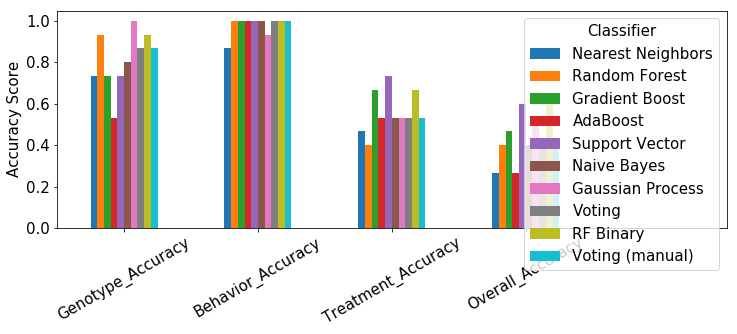

In [19]:
fig, ax = plt.subplots(figsize=(12,4))
_ = accuracy_df.transpose().plot(kind = 'bar', rot = 30, ax=ax)
_ = plt.xlim([-0.5,4.5])
_ = plt.ylabel('Accuracy Score')

In [20]:
import pickle
def save_data(data, filename_no_ext):
    # Uses pickle to save data
    # Filename is given without extension in case method of saving ever changes
    file = open('Output/' + filename_no_ext + '.pickle', 'wb')
    pickle.dump(data, file)
    file.close()
    
def load_data(filename_no_ext):
    # Uses pickle to load data
    file = open('Output/' + filename_no_ext + '.pickle', 'rb')
    data = pickle.load(file)
    file.close()
    return data

In [21]:
AOV_results = pd.read_excel('Output/AOV_Results.xls')
AOV_results.rename(columns = {'Unnamed: 0': 'protein'}, inplace = True)
importance_df_rf = pd.read_csv('Output/FeatureImportances_RandomForest_ScaledData.csv')
importance_df_rf = importance_df_rf.drop('Unnamed: 0', axis = 1)

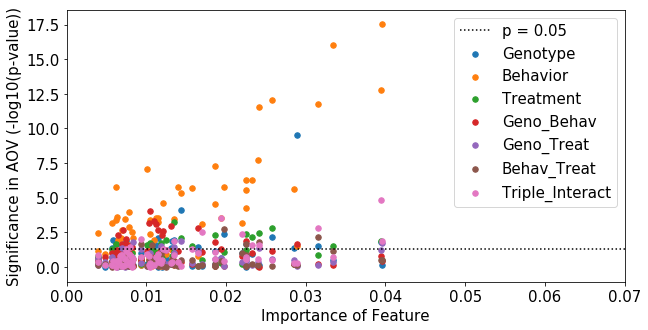

In [22]:
importance_AOV_combine = AOV_results.join(importance_df_rf.set_index('protein'),on = 'protein')

y_columns = importance_AOV_combine.columns[1:-1]
_ = plt.figure(figsize = [10,5])
for y_col in y_columns:
    _ = plt.scatter(x = importance_AOV_combine.importance, y = -np.log10(importance_AOV_combine[y_col]), s = 30)
_ = plt.xlabel('Importance of Feature')
_ = plt.ylabel('Significance in AOV (-log10(p-value))')
_ = plt.axhline(-np.log10(0.05), linestyle = ':', color = 'k')
_ = plt.xlim([0,0.07]) #Just putting in a little extra room for the legend
_ = plt.legend(['p = 0.05']+list(y_columns))

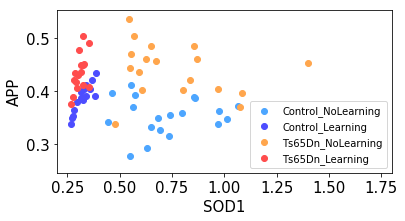

In [48]:
y = data_medians.APP_N
x = data_medians.SOD1_N
YGroup4 = data_medians.Genotype + '_' + data_medians.Behavior
groups4 = ('Control_NoLearning', 'Control_Learning', 'Ts65Dn_NoLearning', 'Ts65Dn_Learning')
colors4 = [colors[2]] + [colors[0]] + [colors[6]] + [colors[4]]

_ = plt.figure(figsize = (6,3))
for idx, group in enumerate(groups4):
    xi = x[YGroup4 == group]
    yi = y[YGroup4 == group]
    _ = plt.scatter(xi, yi, color = colors4[idx])
_ = plt.xlim([0.2,1.8])
_ = plt.xlabel('SOD1')
_ = plt.ylabel('APP')
_ = plt.legend(groups4, fontsize = 10)
_ = plt.show()

[(0.3, 0.65, 1.0), (0.3, 0.3, 1.0), (1.0, 0.65, 0.3), (1.0, 0.3, 0.3)]